##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multimodal understanding with Hugging Face Transformers

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/[Gemma_3n]Multimodal_understanding_with_HF.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

Gemma 3n is a generative AI model optimized for use in everyday devices, such as phones, laptops, and tablets.. This tutorial shows you how to get started running Gemma 3n using Hugging Face Transformers using Image + Audio input to generate text content. The Transformers Python library provides a API for accessing pre-trained generative AI models, including Gemma. For more information, see the [Transformers](https://huggingface.co/docs/transformers/en/index) documentation.

## Setup

Before starting this tutorial, complete the following steps:

* Get access to Gemma by logging into [Hugging Face](https://huggingface.co/google/gemma-3n-E4b-it) and selecting **Acknowledge license** for a Gemma model.
* Select a Colab runtime with sufficient resources to run
  the Gemma model size you want to run. [Learn more](https://ai.google.dev/gemma/docs/core#sizes).
* Generate a Hugging Face [Access Token](https://huggingface.co/docs/hub/en/security-tokens#how-to-manage-user-access-token) and use it to login from Colab.

This notebook will run on an NVIDIA T4 GPU using Gemma 3n E2B.\
But if you want to use Gemma 3n E4B, select L4 or A100.


In [ ]:
# Login into Hugging Face Hub
from huggingface_hub import notebook_login
notebook_login()

### Install Python packages

Install the Hugging Face libraries required for running the Gemma model and making requests.

In [ ]:
# Install a transformers version that supports Gemma 3n (>= 4.53)
!pip install "transformers>=4.53.0"

## Define formatting helper functions

Create a chat helper to manage and display the conversations.

In [1]:
import torch

GEMMA_PATH = "google/gemma-3n-E2B-it" #@param ["google/gemma-3n-E2B-it", "google/gemma-3n-E4B-it"]
RESOURCE_URL_PREFIX = "https://raw.githubusercontent.com/google-gemini/gemma-cookbook/refs/heads/main/Demos/sample-data/"

from IPython.display import Audio, Image, Markdown, display

class ChatState():
  def __init__(self, model, processor):
    self.model = model
    self.processor = processor
    self.history = []

  def send_message(self, message, max_tokens=256):
    self.history.append(message)

    input_ids = self.processor.apply_chat_template(
        self.history,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    )
    input_len = input_ids["input_ids"].shape[-1]

    input_ids = input_ids.to(self.model.device, dtype=model.dtype)
    outputs = self.model.generate(
        **input_ids,
        max_new_tokens=max_tokens,
        disable_compile=True
    )
    text = self.processor.batch_decode(
        outputs[:, input_len:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )
    self.history.append({
        "role": "assistant",
        "content": [
            {"type": "text", "text": text[0]},
        ]
    })

    # display chat
    for item in message['content']:
      if item['type'] == 'text':
        formatted_prompt = "<font size='+1' color='brown'>🙋‍♂️<blockquote>\n" + item['text'] + "\n</blockquote></font>"
        display(Markdown(formatted_prompt))
      elif item['type'] == 'audio':
        display(Audio(item['audio']))
      elif item['type'] == 'image':
        display(Image(item['image']))

    formatted_text = "<font size='+1' color='teal'>🤖<blockquote>\n" + text[0] + "\n</blockquote></font>"
    display(Markdown(formatted_text))


## Load Model

In [3]:
from transformers import AutoModelForImageTextToText, AutoProcessor

processor = AutoProcessor.from_pretrained(GEMMA_PATH)
model = AutoModelForImageTextToText.from_pretrained(GEMMA_PATH, torch_dtype="auto", device_map="auto")

print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/159k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


## Image-in: Captioning

In [5]:
prompt = {
    "role": "user",
    "content": [
        {"type": "image", "image": f"{RESOURCE_URL_PREFIX}kitchen_painting.jpg"},
        {"type": "text", "text": "describe the image in detail"},
    ]
}

chat = ChatState(model, processor)
chat.send_message(prompt, max_tokens=512)

Output hidden; open in https://colab.research.google.com to view.

## Audio + Image : Tour Guide (image in + audio question)

This section demonstrates how to leverage Gemma 3n's multimodal input capability to assist as a Tour Guide. Take a picture of a famous landmark and ask any questions. Gemma 3n will act as your helpful tour guide.


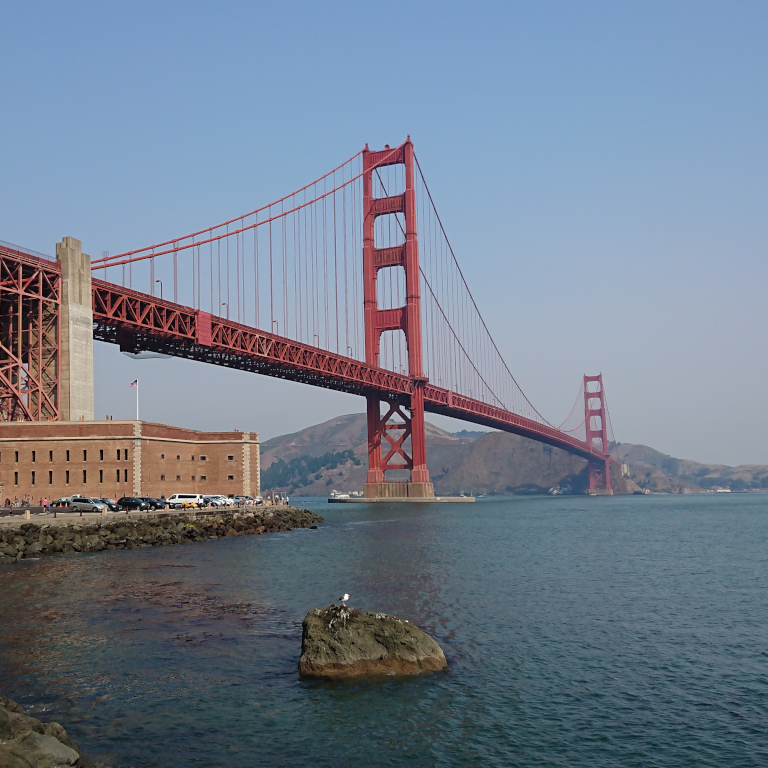

<font size='+1' color='teal'>🤖<blockquote>
The image shows the Golden Gate Bridge in San Francisco, California. It's a famous suspension bridge known for its iconic orange color. 

The bridge spans the Golden Gate strait, connecting San Francisco to Marin County. It's one of the most recognizable landmarks in the world and a popular tourist destination. 

The photo shows the bridge's towers, cables, and the water of the Golden Gate strait below. The sky is clear and blue.
</blockquote></font>

In [6]:
prompt = {
  "role": "user",
  "content": [
    {"type": "image", "image": f"{RESOURCE_URL_PREFIX}GoldenGate.png"},
    {"type": "audio", "audio": f"{RESOURCE_URL_PREFIX}tour_en.wav"},
  ]
}

chat = ChatState(model, processor)
chat.send_message(prompt)

## Try this by yourself

In [ ]:
!pip install ipywebrtc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 5.5 MB/s eta 0:00:00


Press the circle button and start speaking. Click the circle button again when you are finshed. The widget will immediately begin to play back what it captured.

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

from ipywebrtc import AudioRecorder, CameraStream

camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

Convert webm file to wav format that PyTorch can understand.

In [ ]:
with open('/content/recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i /content/recording.webm /content/recording.wav -y

In [ ]:
prompt = {
  "role": "user",
  "content": [
    {"type": "image", "image": f"{RESOURCE_URL_PREFIX}GoldenGate.png"},
    {"type": "audio", "audio": "/content/recording.wav"},
  ]
}
chat = ChatState(model, processor)
chat.send_message(prompt)

## Next steps

Build and explore more with Gemma models:

* [Fine-tune Gemma for text tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_text_finetune_qlora)
* [Fine-tune Gemma for vision tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora)
* [Perform distributed fine-tuning and inference on Gemma models](https://ai.google.dev/gemma/docs/core/distributed_tuning)
* [Use Gemma open models with Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/open-models/use-gemma)
* [Fine-tune Gemma using Keras and deploy to Vertex AI](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_gemma_kerasnlp_to_vertexai.ipynb)